In [1]:
import os
import pandas as pd
import scanpy as sc
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
pth = os.path.join('..', '..')
pth_in = os.path.join(pth, 'data')
pth_data = os.path.join(pth_in, 'placodes')
pth_grn = os.path.join(pth_in, 'scenic', 'E8')
pth_out = os.path.join(pth, 'figures', 'E8')

In [3]:
adata = sc.read_h5ad(os.path.join(pth_data, 'E8.h5ad'))
cat = adata.var.cluster_annotations.to_dict(); adata

AnnData object with n_obs × n_vars = 13690 × 1012
    obs: 'plate', 'day', 'location', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'n_genes', 'doublet_score', 'predicted_doublet', 'batch', 'leiden', 'leiden_refined', 'cluster_annotations'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'n_cells', 'cluster_annotations'
    uns: 'cluster_annotations', 'day_colors', 'hvg', 'leiden', 'location_colors', 'log1p', 'neighbors', 'pca', 'plate_colors', 'rank_genes_groups', 'umap'
    obsm: 'X_pca', 'X_umap'
    obsp: 'connectivities', 'distances'

In [4]:
# load regulons
fn = os.path.join(pth_grn, 'regulons.gmt')
reg = pd.read_csv(fn, header = None)

# construct adjacency matrix
A = pd.DataFrame(columns = adata.var_names)
src = reg[0].str[:-3]
tgt = reg[4].str[1:].str.split('\t')
for i in src.index:
    A.loc[src.loc[i]] = 0
    A.loc[src.loc[i], tgt.loc[i]] = 1

# aggregate edges by TF, target categories
A_cat = A.copy()
A_cat.index = A.index.map(cat).rename('TF Category')
A_cat.columns = A.columns.map(cat).rename('Target Category')
A_cat = (A_cat.groupby('TF Category').sum().T
         .groupby('Target Category').sum().T)
A_cat = A_cat.div(A_cat.sum(axis = 0), axis = 1)
A_cat = A_cat.div(A_cat.sum(axis = 1), axis = 0)
A_cat = A_cat.mul(100)

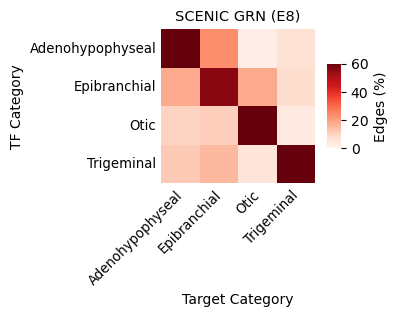

In [5]:
# early GRN segregation (heatmap)
fig, ax = plt.subplots(figsize = (3, 2))
sns.heatmap(A_cat,
            cmap = 'Reds',
            vmin = 0,
            vmax = 60,
            square = True,
            cbar_kws = {
                'shrink' : .55,
                'aspect' : 6,
                'label' : 'Edges (%)'},
            ax = ax)

ax.set_title('SCENIC GRN (E8)', size = 10.5)
ax.tick_params('both', size = 0, labelsize = 9.5)
ax.set_xticklabels(ax.get_xticklabels(),
                   rotation = 45,
                   rotation_mode = 'anchor',
                   ha = 'right', va = 'center')
ax.tick_params('x', pad = 7)
fn = os.path.join(pth_out, 'segregation.pdf')
plt.savefig(fn, bbox_inches = 'tight')